In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np


Using TensorFlow backend.


In [2]:

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

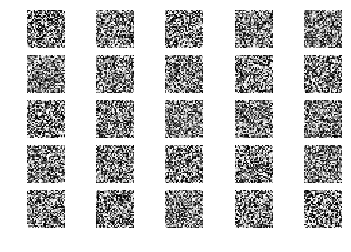

1 [D loss: 0.536644, acc.: 62.50%] [G loss: 0.678098]
2 [D loss: 0.438551, acc.: 71.88%] [G loss: 0.828754]
3 [D loss: 0.343722, acc.: 82.81%] [G loss: 0.913023]
4 [D loss: 0.321824, acc.: 84.38%] [G loss: 1.013385]
5 [D loss: 0.248175, acc.: 92.19%] [G loss: 1.192674]
6 [D loss: 0.232164, acc.: 98.44%] [G loss: 1.264389]
7 [D loss: 0.214780, acc.: 98.44%] [G loss: 1.324671]
8 [D loss: 0.177774, acc.: 100.00%] [G loss: 1.473387]
9 [D loss: 0.168095, acc.: 100.00%] [G loss: 1.570250]
10 [D loss: 0.134165, acc.: 100.00%] [G loss: 1.580051]
11 [D loss: 0.158987, acc.: 100.00%] [G loss: 1.705509]
12 [D loss: 0.132551, acc.: 100.00%] [G loss: 1.813181]
13 [D loss: 0.133266, acc.: 100.00%] [G loss: 1.978439]
14 [D loss: 0.102929, acc.: 100.00%] [G loss: 1.984707]
15 [D loss: 0.089714, acc.: 100.00%] [G loss: 2.174922]
16 [D loss: 0.099555, acc.: 100.00%] [G loss: 2.110053]
17 [D loss: 0.084015, acc.: 100.00%] [G loss: 2.214097]
18 [D loss: 0.093889, acc.: 100.00%] [G loss: 2.238181]
19 [D lo

150 [D loss: 0.168525, acc.: 95.31%] [G loss: 3.471697]
151 [D loss: 0.240487, acc.: 95.31%] [G loss: 3.580349]
152 [D loss: 0.414671, acc.: 79.69%] [G loss: 3.518736]
153 [D loss: 0.203534, acc.: 92.19%] [G loss: 3.125981]
154 [D loss: 0.228465, acc.: 90.62%] [G loss: 3.269966]
155 [D loss: 0.585278, acc.: 79.69%] [G loss: 3.128660]
156 [D loss: 0.123999, acc.: 98.44%] [G loss: 3.924072]
157 [D loss: 0.310826, acc.: 85.94%] [G loss: 3.436315]
158 [D loss: 0.110811, acc.: 93.75%] [G loss: 4.096550]
159 [D loss: 0.592488, acc.: 73.44%] [G loss: 2.873330]
160 [D loss: 0.389204, acc.: 84.38%] [G loss: 3.279828]
161 [D loss: 0.241267, acc.: 96.88%] [G loss: 3.514712]
162 [D loss: 0.438921, acc.: 81.25%] [G loss: 2.616240]
163 [D loss: 0.296712, acc.: 87.50%] [G loss: 2.720985]
164 [D loss: 0.360931, acc.: 84.38%] [G loss: 2.685191]
165 [D loss: 0.136302, acc.: 98.44%] [G loss: 3.387692]
166 [D loss: 0.321655, acc.: 90.62%] [G loss: 3.119687]
167 [D loss: 0.314115, acc.: 84.38%] [G loss: 3.

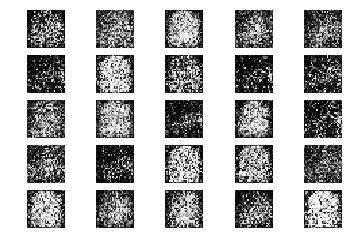

201 [D loss: 0.463498, acc.: 70.31%] [G loss: 4.093769]
202 [D loss: 0.644781, acc.: 71.88%] [G loss: 1.737243]
203 [D loss: 0.284798, acc.: 92.19%] [G loss: 2.505742]
204 [D loss: 0.427437, acc.: 87.50%] [G loss: 2.986465]
205 [D loss: 0.458586, acc.: 70.31%] [G loss: 2.913582]
206 [D loss: 1.192223, acc.: 50.00%] [G loss: 1.579322]
207 [D loss: 0.472728, acc.: 71.88%] [G loss: 2.582039]
208 [D loss: 0.477317, acc.: 81.25%] [G loss: 2.792173]
209 [D loss: 0.504147, acc.: 78.12%] [G loss: 2.423920]
210 [D loss: 0.412017, acc.: 82.81%] [G loss: 2.362500]
211 [D loss: 0.596725, acc.: 73.44%] [G loss: 2.415006]
212 [D loss: 0.623979, acc.: 65.62%] [G loss: 2.287066]
213 [D loss: 0.423603, acc.: 78.12%] [G loss: 2.284806]
214 [D loss: 0.674174, acc.: 68.75%] [G loss: 2.156563]
215 [D loss: 0.733983, acc.: 54.69%] [G loss: 2.246404]
216 [D loss: 0.355930, acc.: 85.94%] [G loss: 2.191067]
217 [D loss: 0.511363, acc.: 67.19%] [G loss: 2.762950]
218 [D loss: 0.692057, acc.: 59.38%] [G loss: 1.

349 [D loss: 0.753889, acc.: 59.38%] [G loss: 0.912848]
350 [D loss: 0.656914, acc.: 56.25%] [G loss: 0.853704]
351 [D loss: 0.735958, acc.: 50.00%] [G loss: 0.973730]
352 [D loss: 0.702254, acc.: 53.12%] [G loss: 0.929947]
353 [D loss: 0.789590, acc.: 45.31%] [G loss: 0.902626]
354 [D loss: 0.699150, acc.: 57.81%] [G loss: 0.871532]
355 [D loss: 0.685629, acc.: 51.56%] [G loss: 0.851510]
356 [D loss: 0.677911, acc.: 60.94%] [G loss: 0.930727]
357 [D loss: 0.677158, acc.: 56.25%] [G loss: 0.934089]
358 [D loss: 0.773883, acc.: 50.00%] [G loss: 0.886596]
359 [D loss: 0.667035, acc.: 62.50%] [G loss: 0.920188]
360 [D loss: 0.764500, acc.: 53.12%] [G loss: 0.894571]
361 [D loss: 0.678004, acc.: 60.94%] [G loss: 0.864756]
362 [D loss: 0.701970, acc.: 57.81%] [G loss: 0.876872]
363 [D loss: 0.643145, acc.: 62.50%] [G loss: 0.856494]
364 [D loss: 0.650881, acc.: 65.62%] [G loss: 0.917190]
365 [D loss: 0.696166, acc.: 53.12%] [G loss: 0.924913]
366 [D loss: 0.665844, acc.: 70.31%] [G loss: 0.

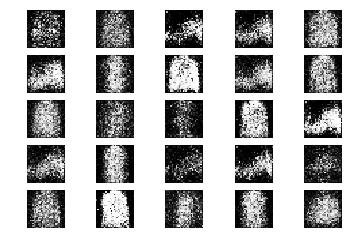

401 [D loss: 0.614425, acc.: 67.19%] [G loss: 0.884528]
402 [D loss: 0.683430, acc.: 62.50%] [G loss: 0.883959]
403 [D loss: 0.620220, acc.: 68.75%] [G loss: 0.888477]
404 [D loss: 0.702069, acc.: 60.94%] [G loss: 0.961599]
405 [D loss: 0.626771, acc.: 68.75%] [G loss: 1.065381]
406 [D loss: 0.655818, acc.: 70.31%] [G loss: 0.928038]
407 [D loss: 0.691006, acc.: 56.25%] [G loss: 0.860965]
408 [D loss: 0.640051, acc.: 64.06%] [G loss: 0.894826]
409 [D loss: 0.596320, acc.: 64.06%] [G loss: 0.951062]
410 [D loss: 0.622082, acc.: 70.31%] [G loss: 0.961885]
411 [D loss: 0.580521, acc.: 70.31%] [G loss: 0.982568]
412 [D loss: 0.630674, acc.: 65.62%] [G loss: 0.973646]
413 [D loss: 0.553877, acc.: 75.00%] [G loss: 0.949191]
414 [D loss: 0.684211, acc.: 67.19%] [G loss: 0.890132]
415 [D loss: 0.595939, acc.: 71.88%] [G loss: 0.973172]
416 [D loss: 0.661223, acc.: 60.94%] [G loss: 0.899432]
417 [D loss: 0.666588, acc.: 64.06%] [G loss: 0.883429]
418 [D loss: 0.666148, acc.: 59.38%] [G loss: 0.

548 [D loss: 0.647061, acc.: 60.94%] [G loss: 0.883243]
549 [D loss: 0.641422, acc.: 64.06%] [G loss: 0.895133]
550 [D loss: 0.693778, acc.: 62.50%] [G loss: 0.843029]
551 [D loss: 0.653841, acc.: 60.94%] [G loss: 0.854381]
552 [D loss: 0.625613, acc.: 62.50%] [G loss: 0.844114]
553 [D loss: 0.643397, acc.: 65.62%] [G loss: 0.865190]
554 [D loss: 0.628425, acc.: 67.19%] [G loss: 0.849797]
555 [D loss: 0.595074, acc.: 71.88%] [G loss: 0.907631]
556 [D loss: 0.657022, acc.: 54.69%] [G loss: 0.908001]
557 [D loss: 0.665548, acc.: 56.25%] [G loss: 0.883748]
558 [D loss: 0.671023, acc.: 60.94%] [G loss: 0.852111]
559 [D loss: 0.649883, acc.: 64.06%] [G loss: 0.856547]
560 [D loss: 0.616736, acc.: 71.88%] [G loss: 0.903614]
561 [D loss: 0.648156, acc.: 62.50%] [G loss: 0.830194]
562 [D loss: 0.613809, acc.: 68.75%] [G loss: 0.938551]
563 [D loss: 0.616900, acc.: 67.19%] [G loss: 0.817194]
564 [D loss: 0.628154, acc.: 57.81%] [G loss: 0.847486]
565 [D loss: 0.548926, acc.: 70.31%] [G loss: 0.

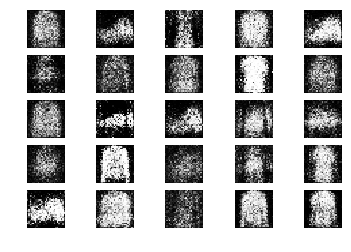

601 [D loss: 0.671164, acc.: 54.69%] [G loss: 0.887039]
602 [D loss: 0.636458, acc.: 64.06%] [G loss: 0.847501]
603 [D loss: 0.600857, acc.: 68.75%] [G loss: 0.821920]
604 [D loss: 0.646618, acc.: 62.50%] [G loss: 0.890056]
605 [D loss: 0.648503, acc.: 60.94%] [G loss: 0.846350]
606 [D loss: 0.634608, acc.: 62.50%] [G loss: 0.879477]
607 [D loss: 0.635903, acc.: 62.50%] [G loss: 0.840879]
608 [D loss: 0.556477, acc.: 76.56%] [G loss: 0.930398]
609 [D loss: 0.599258, acc.: 67.19%] [G loss: 0.853388]
610 [D loss: 0.620658, acc.: 60.94%] [G loss: 0.833514]
611 [D loss: 0.611558, acc.: 67.19%] [G loss: 0.787226]
612 [D loss: 0.613205, acc.: 67.19%] [G loss: 0.816326]
613 [D loss: 0.688511, acc.: 57.81%] [G loss: 0.896663]
614 [D loss: 0.603312, acc.: 64.06%] [G loss: 0.907329]
615 [D loss: 0.638299, acc.: 65.62%] [G loss: 0.841229]
616 [D loss: 0.673571, acc.: 62.50%] [G loss: 0.831441]
617 [D loss: 0.646394, acc.: 67.19%] [G loss: 0.923077]
618 [D loss: 0.613197, acc.: 67.19%] [G loss: 0.

747 [D loss: 0.683206, acc.: 57.81%] [G loss: 0.814548]
748 [D loss: 0.623249, acc.: 65.62%] [G loss: 0.868166]
749 [D loss: 0.638772, acc.: 65.62%] [G loss: 0.896678]
750 [D loss: 0.603431, acc.: 64.06%] [G loss: 0.871090]
751 [D loss: 0.653669, acc.: 60.94%] [G loss: 0.822961]
752 [D loss: 0.646125, acc.: 60.94%] [G loss: 0.919029]
753 [D loss: 0.661605, acc.: 64.06%] [G loss: 0.930647]
754 [D loss: 0.561157, acc.: 75.00%] [G loss: 0.977378]
755 [D loss: 0.646984, acc.: 51.56%] [G loss: 0.869022]
756 [D loss: 0.636884, acc.: 64.06%] [G loss: 0.859408]
757 [D loss: 0.643179, acc.: 64.06%] [G loss: 0.805756]
758 [D loss: 0.627041, acc.: 65.62%] [G loss: 0.856132]
759 [D loss: 0.597029, acc.: 70.31%] [G loss: 0.899382]
760 [D loss: 0.645750, acc.: 65.62%] [G loss: 0.865173]
761 [D loss: 0.653087, acc.: 64.06%] [G loss: 0.833468]
762 [D loss: 0.649321, acc.: 64.06%] [G loss: 0.833533]
763 [D loss: 0.652660, acc.: 59.38%] [G loss: 0.859276]
764 [D loss: 0.683756, acc.: 57.81%] [G loss: 0.

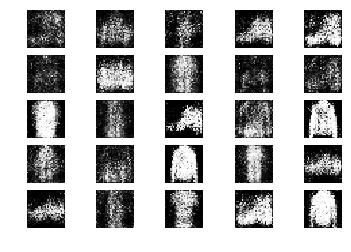

801 [D loss: 0.589216, acc.: 78.12%] [G loss: 0.795747]
802 [D loss: 0.667047, acc.: 54.69%] [G loss: 0.796734]
803 [D loss: 0.622244, acc.: 54.69%] [G loss: 0.790684]
804 [D loss: 0.576840, acc.: 71.88%] [G loss: 0.911336]
805 [D loss: 0.631510, acc.: 57.81%] [G loss: 0.867820]
806 [D loss: 0.591259, acc.: 70.31%] [G loss: 0.924443]
807 [D loss: 0.632234, acc.: 68.75%] [G loss: 0.914056]
808 [D loss: 0.645962, acc.: 57.81%] [G loss: 0.814457]
809 [D loss: 0.662917, acc.: 65.62%] [G loss: 0.787041]
810 [D loss: 0.662937, acc.: 59.38%] [G loss: 0.821833]
811 [D loss: 0.700397, acc.: 51.56%] [G loss: 0.817838]
812 [D loss: 0.675134, acc.: 56.25%] [G loss: 0.900303]
813 [D loss: 0.568718, acc.: 84.38%] [G loss: 0.905916]
814 [D loss: 0.606531, acc.: 71.88%] [G loss: 0.885062]
815 [D loss: 0.584348, acc.: 75.00%] [G loss: 0.834072]
816 [D loss: 0.669784, acc.: 57.81%] [G loss: 0.903095]
817 [D loss: 0.678599, acc.: 67.19%] [G loss: 0.840039]
818 [D loss: 0.632727, acc.: 67.19%] [G loss: 0.

951 [D loss: 0.696367, acc.: 53.12%] [G loss: 0.865432]
952 [D loss: 0.674605, acc.: 51.56%] [G loss: 0.824895]
953 [D loss: 0.659624, acc.: 56.25%] [G loss: 0.858157]
954 [D loss: 0.624581, acc.: 65.62%] [G loss: 0.803939]
955 [D loss: 0.640119, acc.: 64.06%] [G loss: 0.850823]
956 [D loss: 0.610866, acc.: 73.44%] [G loss: 0.801541]
957 [D loss: 0.573130, acc.: 75.00%] [G loss: 0.817947]
958 [D loss: 0.612081, acc.: 60.94%] [G loss: 0.877268]
959 [D loss: 0.686205, acc.: 68.75%] [G loss: 0.839269]
960 [D loss: 0.677940, acc.: 67.19%] [G loss: 0.789196]
961 [D loss: 0.664222, acc.: 59.38%] [G loss: 0.804025]
962 [D loss: 0.658622, acc.: 68.75%] [G loss: 0.838777]
963 [D loss: 0.647355, acc.: 67.19%] [G loss: 0.855450]
964 [D loss: 0.595897, acc.: 64.06%] [G loss: 0.759097]
965 [D loss: 0.679998, acc.: 59.38%] [G loss: 0.785285]
966 [D loss: 0.641489, acc.: 67.19%] [G loss: 0.740488]
967 [D loss: 0.696636, acc.: 51.56%] [G loss: 0.860944]
968 [D loss: 0.624390, acc.: 57.81%] [G loss: 0.

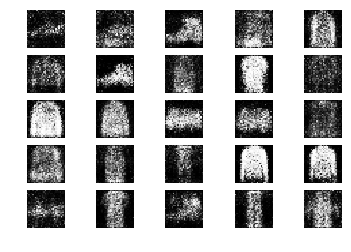

1001 [D loss: 0.643003, acc.: 62.50%] [G loss: 0.790187]
1002 [D loss: 0.633705, acc.: 65.62%] [G loss: 0.869641]
1003 [D loss: 0.606718, acc.: 68.75%] [G loss: 0.884510]
1004 [D loss: 0.640938, acc.: 68.75%] [G loss: 0.815057]
1005 [D loss: 0.651760, acc.: 60.94%] [G loss: 0.822244]
1006 [D loss: 0.617278, acc.: 67.19%] [G loss: 0.769467]
1007 [D loss: 0.685280, acc.: 48.44%] [G loss: 0.753094]
1008 [D loss: 0.604347, acc.: 57.81%] [G loss: 0.750679]
1009 [D loss: 0.609526, acc.: 65.62%] [G loss: 0.771817]
1010 [D loss: 0.643786, acc.: 65.62%] [G loss: 0.760029]
1011 [D loss: 0.606043, acc.: 65.62%] [G loss: 0.888197]
1012 [D loss: 0.640853, acc.: 67.19%] [G loss: 0.864548]
1013 [D loss: 0.596137, acc.: 73.44%] [G loss: 0.783554]
1014 [D loss: 0.648128, acc.: 62.50%] [G loss: 0.823186]
1015 [D loss: 0.570554, acc.: 73.44%] [G loss: 0.810760]
1016 [D loss: 0.588362, acc.: 67.19%] [G loss: 0.915067]
1017 [D loss: 0.677417, acc.: 64.06%] [G loss: 0.845873]
1018 [D loss: 0.657706, acc.: 5

1145 [D loss: 0.650403, acc.: 60.94%] [G loss: 0.893891]
1146 [D loss: 0.644452, acc.: 60.94%] [G loss: 0.848623]
1147 [D loss: 0.624121, acc.: 68.75%] [G loss: 0.820631]
1148 [D loss: 0.683142, acc.: 50.00%] [G loss: 0.885583]
1149 [D loss: 0.661377, acc.: 60.94%] [G loss: 0.880676]
1150 [D loss: 0.600081, acc.: 65.62%] [G loss: 0.810926]
1151 [D loss: 0.649660, acc.: 62.50%] [G loss: 0.869481]
1152 [D loss: 0.661225, acc.: 59.38%] [G loss: 0.854685]
1153 [D loss: 0.652472, acc.: 64.06%] [G loss: 0.804900]
1154 [D loss: 0.665558, acc.: 59.38%] [G loss: 0.833835]
1155 [D loss: 0.683903, acc.: 65.62%] [G loss: 0.802450]
1156 [D loss: 0.639189, acc.: 67.19%] [G loss: 0.788634]
1157 [D loss: 0.661948, acc.: 60.94%] [G loss: 0.851840]
1158 [D loss: 0.595473, acc.: 68.75%] [G loss: 0.832514]
1159 [D loss: 0.664834, acc.: 57.81%] [G loss: 0.817126]
1160 [D loss: 0.652830, acc.: 59.38%] [G loss: 0.865733]
1161 [D loss: 0.682114, acc.: 54.69%] [G loss: 0.878329]
1162 [D loss: 0.614803, acc.: 6

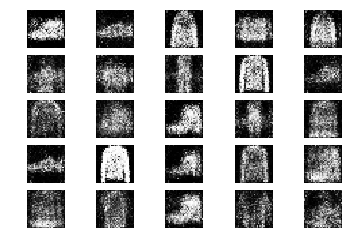

1201 [D loss: 0.639571, acc.: 64.06%] [G loss: 0.918865]
1202 [D loss: 0.609348, acc.: 65.62%] [G loss: 0.842385]
1203 [D loss: 0.620476, acc.: 64.06%] [G loss: 0.865677]
1204 [D loss: 0.728013, acc.: 45.31%] [G loss: 0.865191]
1205 [D loss: 0.599115, acc.: 73.44%] [G loss: 0.883421]
1206 [D loss: 0.644469, acc.: 64.06%] [G loss: 0.786675]
1207 [D loss: 0.624142, acc.: 65.62%] [G loss: 0.798180]
1208 [D loss: 0.638237, acc.: 65.62%] [G loss: 0.815541]
1209 [D loss: 0.640398, acc.: 65.62%] [G loss: 0.932772]
1210 [D loss: 0.653792, acc.: 64.06%] [G loss: 0.904790]
1211 [D loss: 0.617293, acc.: 67.19%] [G loss: 0.799436]
1212 [D loss: 0.593501, acc.: 71.88%] [G loss: 0.860623]
1213 [D loss: 0.617379, acc.: 65.62%] [G loss: 0.832372]
1214 [D loss: 0.669131, acc.: 62.50%] [G loss: 0.801849]
1215 [D loss: 0.659090, acc.: 62.50%] [G loss: 0.826498]
1216 [D loss: 0.628212, acc.: 62.50%] [G loss: 0.838542]
1217 [D loss: 0.698101, acc.: 48.44%] [G loss: 0.861321]
1218 [D loss: 0.644011, acc.: 6

1344 [D loss: 0.700596, acc.: 62.50%] [G loss: 0.856603]
1345 [D loss: 0.628647, acc.: 60.94%] [G loss: 0.790079]
1346 [D loss: 0.626688, acc.: 70.31%] [G loss: 0.921727]
1347 [D loss: 0.607320, acc.: 67.19%] [G loss: 0.898008]
1348 [D loss: 0.566525, acc.: 75.00%] [G loss: 0.940894]
1349 [D loss: 0.621050, acc.: 67.19%] [G loss: 0.939365]
1350 [D loss: 0.631058, acc.: 65.62%] [G loss: 0.838284]
1351 [D loss: 0.645070, acc.: 64.06%] [G loss: 0.860593]
1352 [D loss: 0.641828, acc.: 62.50%] [G loss: 0.822834]
1353 [D loss: 0.619990, acc.: 67.19%] [G loss: 0.856705]
1354 [D loss: 0.605845, acc.: 68.75%] [G loss: 0.867307]
1355 [D loss: 0.687308, acc.: 62.50%] [G loss: 0.922586]
1356 [D loss: 0.651547, acc.: 62.50%] [G loss: 0.901715]
1357 [D loss: 0.640895, acc.: 62.50%] [G loss: 0.818996]
1358 [D loss: 0.602635, acc.: 64.06%] [G loss: 0.910852]
1359 [D loss: 0.704520, acc.: 56.25%] [G loss: 0.847213]
1360 [D loss: 0.682110, acc.: 54.69%] [G loss: 0.889808]
1361 [D loss: 0.647619, acc.: 6

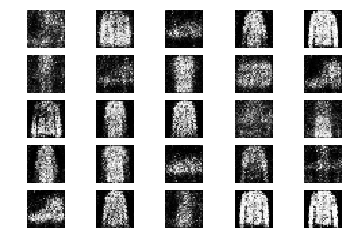

1401 [D loss: 0.617862, acc.: 65.62%] [G loss: 0.918574]
1402 [D loss: 0.620983, acc.: 64.06%] [G loss: 0.851117]
1403 [D loss: 0.624981, acc.: 67.19%] [G loss: 0.864622]
1404 [D loss: 0.605159, acc.: 64.06%] [G loss: 0.893965]
1405 [D loss: 0.564477, acc.: 67.19%] [G loss: 0.903815]
1406 [D loss: 0.644777, acc.: 62.50%] [G loss: 0.840262]
1407 [D loss: 0.726364, acc.: 57.81%] [G loss: 0.895949]
1408 [D loss: 0.695967, acc.: 53.12%] [G loss: 0.803180]
1409 [D loss: 0.643837, acc.: 56.25%] [G loss: 0.848157]
1410 [D loss: 0.625559, acc.: 70.31%] [G loss: 0.798439]
1411 [D loss: 0.671415, acc.: 57.81%] [G loss: 0.812104]
1412 [D loss: 0.620334, acc.: 56.25%] [G loss: 0.798548]
1413 [D loss: 0.626510, acc.: 68.75%] [G loss: 0.875017]
1414 [D loss: 0.718847, acc.: 51.56%] [G loss: 0.823286]
1415 [D loss: 0.618495, acc.: 62.50%] [G loss: 0.910634]
1416 [D loss: 0.650586, acc.: 60.94%] [G loss: 0.853860]
1417 [D loss: 0.601695, acc.: 73.44%] [G loss: 0.855536]
1418 [D loss: 0.669138, acc.: 6

1546 [D loss: 0.643796, acc.: 62.50%] [G loss: 0.888435]
1547 [D loss: 0.605773, acc.: 65.62%] [G loss: 0.915327]
1548 [D loss: 0.615941, acc.: 64.06%] [G loss: 0.884694]
1549 [D loss: 0.608332, acc.: 70.31%] [G loss: 0.885208]
1550 [D loss: 0.684451, acc.: 56.25%] [G loss: 0.851715]
1551 [D loss: 0.636881, acc.: 62.50%] [G loss: 0.811967]
1552 [D loss: 0.610498, acc.: 68.75%] [G loss: 0.888985]
1553 [D loss: 0.658140, acc.: 59.38%] [G loss: 0.884818]
1554 [D loss: 0.619766, acc.: 71.88%] [G loss: 0.847587]
1555 [D loss: 0.625832, acc.: 62.50%] [G loss: 0.865114]
1556 [D loss: 0.683782, acc.: 53.12%] [G loss: 0.895088]
1557 [D loss: 0.630974, acc.: 67.19%] [G loss: 0.937942]
1558 [D loss: 0.682519, acc.: 57.81%] [G loss: 0.861463]
1559 [D loss: 0.654611, acc.: 64.06%] [G loss: 0.914405]
1560 [D loss: 0.578514, acc.: 71.88%] [G loss: 0.905401]
1561 [D loss: 0.607601, acc.: 67.19%] [G loss: 0.904010]
1562 [D loss: 0.566303, acc.: 73.44%] [G loss: 0.823042]
1563 [D loss: 0.625590, acc.: 6

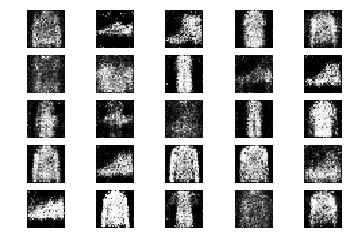

1601 [D loss: 0.659502, acc.: 60.94%] [G loss: 0.972876]
1602 [D loss: 0.675093, acc.: 59.38%] [G loss: 0.894057]
1603 [D loss: 0.588106, acc.: 73.44%] [G loss: 0.861591]
1604 [D loss: 0.644016, acc.: 62.50%] [G loss: 0.881827]
1605 [D loss: 0.608193, acc.: 68.75%] [G loss: 0.862901]
1606 [D loss: 0.623511, acc.: 67.19%] [G loss: 0.804478]
1607 [D loss: 0.608881, acc.: 71.88%] [G loss: 0.820040]
1608 [D loss: 0.645242, acc.: 59.38%] [G loss: 0.865150]
1609 [D loss: 0.579037, acc.: 71.88%] [G loss: 0.899149]
1610 [D loss: 0.678477, acc.: 62.50%] [G loss: 0.938425]
1611 [D loss: 0.613032, acc.: 68.75%] [G loss: 0.921405]
1612 [D loss: 0.600831, acc.: 68.75%] [G loss: 0.850907]
1613 [D loss: 0.637877, acc.: 65.62%] [G loss: 0.922401]
1614 [D loss: 0.706988, acc.: 51.56%] [G loss: 0.866763]
1615 [D loss: 0.626682, acc.: 60.94%] [G loss: 0.908893]
1616 [D loss: 0.616599, acc.: 65.62%] [G loss: 0.994825]
1617 [D loss: 0.587171, acc.: 73.44%] [G loss: 0.914151]
1618 [D loss: 0.650851, acc.: 6

1749 [D loss: 0.622299, acc.: 68.75%] [G loss: 0.916337]
1750 [D loss: 0.630457, acc.: 64.06%] [G loss: 0.884131]
1751 [D loss: 0.570533, acc.: 73.44%] [G loss: 0.893947]
1752 [D loss: 0.667508, acc.: 57.81%] [G loss: 0.853614]
1753 [D loss: 0.596902, acc.: 68.75%] [G loss: 0.944173]
1754 [D loss: 0.601668, acc.: 65.62%] [G loss: 0.846045]
1755 [D loss: 0.672050, acc.: 51.56%] [G loss: 0.870489]
1756 [D loss: 0.658752, acc.: 64.06%] [G loss: 1.022623]
1757 [D loss: 0.599102, acc.: 67.19%] [G loss: 1.022871]
1758 [D loss: 0.558448, acc.: 76.56%] [G loss: 0.994933]
1759 [D loss: 0.649928, acc.: 57.81%] [G loss: 0.945745]
1760 [D loss: 0.646160, acc.: 65.62%] [G loss: 0.879468]
1761 [D loss: 0.652277, acc.: 67.19%] [G loss: 0.889068]
1762 [D loss: 0.626193, acc.: 71.88%] [G loss: 0.969179]
1763 [D loss: 0.572120, acc.: 79.69%] [G loss: 0.911981]
1764 [D loss: 0.623588, acc.: 60.94%] [G loss: 0.988979]
1765 [D loss: 0.610183, acc.: 65.62%] [G loss: 0.921179]
1766 [D loss: 0.598809, acc.: 6

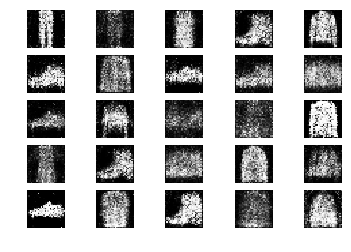

1801 [D loss: 0.663788, acc.: 64.06%] [G loss: 0.849684]
1802 [D loss: 0.688157, acc.: 56.25%] [G loss: 0.892360]
1803 [D loss: 0.575608, acc.: 75.00%] [G loss: 0.944576]
1804 [D loss: 0.640934, acc.: 67.19%] [G loss: 0.980809]
1805 [D loss: 0.602858, acc.: 65.62%] [G loss: 0.880013]
1806 [D loss: 0.541897, acc.: 78.12%] [G loss: 0.873908]
1807 [D loss: 0.644660, acc.: 68.75%] [G loss: 0.878350]
1808 [D loss: 0.641375, acc.: 62.50%] [G loss: 0.795494]
1809 [D loss: 0.627193, acc.: 64.06%] [G loss: 0.823829]
1810 [D loss: 0.651202, acc.: 57.81%] [G loss: 0.860424]
1811 [D loss: 0.547620, acc.: 76.56%] [G loss: 0.886392]
1812 [D loss: 0.565173, acc.: 70.31%] [G loss: 0.920886]
1813 [D loss: 0.595069, acc.: 67.19%] [G loss: 0.997003]
1814 [D loss: 0.635891, acc.: 62.50%] [G loss: 0.935446]
1815 [D loss: 0.601907, acc.: 68.75%] [G loss: 0.845970]
1816 [D loss: 0.624381, acc.: 65.62%] [G loss: 0.939294]
1817 [D loss: 0.675380, acc.: 57.81%] [G loss: 0.883040]
1818 [D loss: 0.624715, acc.: 6

1944 [D loss: 0.617756, acc.: 67.19%] [G loss: 0.883523]
1945 [D loss: 0.579695, acc.: 71.88%] [G loss: 0.920416]
1946 [D loss: 0.645674, acc.: 59.38%] [G loss: 0.824515]
1947 [D loss: 0.556561, acc.: 73.44%] [G loss: 0.882169]
1948 [D loss: 0.681589, acc.: 57.81%] [G loss: 0.829547]
1949 [D loss: 0.667360, acc.: 54.69%] [G loss: 0.816784]
1950 [D loss: 0.626137, acc.: 67.19%] [G loss: 0.882020]
1951 [D loss: 0.670403, acc.: 51.56%] [G loss: 0.899282]
1952 [D loss: 0.643229, acc.: 59.38%] [G loss: 0.851450]
1953 [D loss: 0.623397, acc.: 65.62%] [G loss: 0.876520]
1954 [D loss: 0.605855, acc.: 67.19%] [G loss: 0.945903]
1955 [D loss: 0.690123, acc.: 54.69%] [G loss: 0.865236]
1956 [D loss: 0.625337, acc.: 65.62%] [G loss: 0.885541]
1957 [D loss: 0.602068, acc.: 68.75%] [G loss: 0.837662]
1958 [D loss: 0.650121, acc.: 53.12%] [G loss: 0.853504]
1959 [D loss: 0.681828, acc.: 56.25%] [G loss: 0.858739]
1960 [D loss: 0.622346, acc.: 65.62%] [G loss: 0.804882]
1961 [D loss: 0.675309, acc.: 5

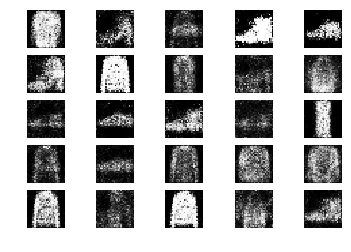

2001 [D loss: 0.664704, acc.: 59.38%] [G loss: 0.953367]
2002 [D loss: 0.639503, acc.: 65.62%] [G loss: 0.957018]
2003 [D loss: 0.642933, acc.: 65.62%] [G loss: 0.906318]
2004 [D loss: 0.618791, acc.: 71.88%] [G loss: 0.921913]
2005 [D loss: 0.618703, acc.: 65.62%] [G loss: 0.923859]
2006 [D loss: 0.662044, acc.: 59.38%] [G loss: 0.836693]
2007 [D loss: 0.663407, acc.: 60.94%] [G loss: 0.771595]
2008 [D loss: 0.666508, acc.: 51.56%] [G loss: 0.861043]
2009 [D loss: 0.665241, acc.: 54.69%] [G loss: 0.889168]
2010 [D loss: 0.666999, acc.: 53.12%] [G loss: 0.916031]
2011 [D loss: 0.601668, acc.: 68.75%] [G loss: 0.925269]
2012 [D loss: 0.613330, acc.: 71.88%] [G loss: 0.852715]
2013 [D loss: 0.696459, acc.: 57.81%] [G loss: 0.942823]
2014 [D loss: 0.627451, acc.: 59.38%] [G loss: 0.897504]
2015 [D loss: 0.633960, acc.: 68.75%] [G loss: 0.889470]
2016 [D loss: 0.656200, acc.: 64.06%] [G loss: 0.899432]
2017 [D loss: 0.710280, acc.: 53.12%] [G loss: 0.896833]
2018 [D loss: 0.565088, acc.: 7

2147 [D loss: 0.665475, acc.: 53.12%] [G loss: 0.770989]
2148 [D loss: 0.611985, acc.: 62.50%] [G loss: 0.847142]
2149 [D loss: 0.676280, acc.: 53.12%] [G loss: 0.854951]
2150 [D loss: 0.621124, acc.: 68.75%] [G loss: 0.806398]
2151 [D loss: 0.634902, acc.: 60.94%] [G loss: 0.893632]
2152 [D loss: 0.594654, acc.: 75.00%] [G loss: 0.898054]
2153 [D loss: 0.601150, acc.: 62.50%] [G loss: 1.007565]
2154 [D loss: 0.679460, acc.: 56.25%] [G loss: 0.987436]
2155 [D loss: 0.559762, acc.: 75.00%] [G loss: 0.968231]
2156 [D loss: 0.646784, acc.: 70.31%] [G loss: 0.835957]
2157 [D loss: 0.657300, acc.: 57.81%] [G loss: 0.848099]
2158 [D loss: 0.598081, acc.: 75.00%] [G loss: 0.877103]
2159 [D loss: 0.626416, acc.: 65.62%] [G loss: 0.888738]
2160 [D loss: 0.606309, acc.: 71.88%] [G loss: 0.875749]
2161 [D loss: 0.639937, acc.: 68.75%] [G loss: 0.872329]
2162 [D loss: 0.690421, acc.: 53.12%] [G loss: 0.832515]
2163 [D loss: 0.623791, acc.: 67.19%] [G loss: 0.888445]
2164 [D loss: 0.626422, acc.: 6

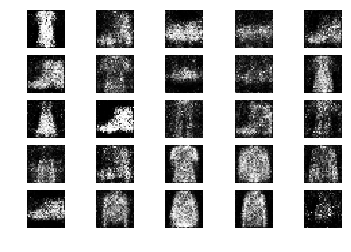

2201 [D loss: 0.658393, acc.: 57.81%] [G loss: 0.778290]
2202 [D loss: 0.644731, acc.: 64.06%] [G loss: 0.833125]
2203 [D loss: 0.663546, acc.: 54.69%] [G loss: 0.807982]
2204 [D loss: 0.585512, acc.: 73.44%] [G loss: 0.875699]
2205 [D loss: 0.649848, acc.: 59.38%] [G loss: 0.879845]
2206 [D loss: 0.634100, acc.: 64.06%] [G loss: 0.890653]
2207 [D loss: 0.633732, acc.: 59.38%] [G loss: 0.844895]
2208 [D loss: 0.591990, acc.: 67.19%] [G loss: 0.993481]
2209 [D loss: 0.725580, acc.: 43.75%] [G loss: 0.878753]
2210 [D loss: 0.653638, acc.: 60.94%] [G loss: 0.853937]
2211 [D loss: 0.597579, acc.: 73.44%] [G loss: 0.838165]
2212 [D loss: 0.594500, acc.: 67.19%] [G loss: 0.961382]
2213 [D loss: 0.614649, acc.: 64.06%] [G loss: 0.960366]
2214 [D loss: 0.637019, acc.: 64.06%] [G loss: 0.899635]
2215 [D loss: 0.618937, acc.: 71.88%] [G loss: 0.853074]
2216 [D loss: 0.612382, acc.: 67.19%] [G loss: 0.891679]
2217 [D loss: 0.650318, acc.: 64.06%] [G loss: 0.873201]
2218 [D loss: 0.590924, acc.: 7

2345 [D loss: 0.671079, acc.: 59.38%] [G loss: 0.956036]
2346 [D loss: 0.641471, acc.: 65.62%] [G loss: 0.856559]
2347 [D loss: 0.696410, acc.: 53.12%] [G loss: 0.872812]
2348 [D loss: 0.627801, acc.: 65.62%] [G loss: 0.887947]
2349 [D loss: 0.632707, acc.: 67.19%] [G loss: 0.881053]
2350 [D loss: 0.553554, acc.: 79.69%] [G loss: 0.953351]
2351 [D loss: 0.585605, acc.: 76.56%] [G loss: 0.891082]
2352 [D loss: 0.646779, acc.: 64.06%] [G loss: 0.895681]
2353 [D loss: 0.593529, acc.: 76.56%] [G loss: 0.845004]
2354 [D loss: 0.573245, acc.: 70.31%] [G loss: 0.815303]
2355 [D loss: 0.638035, acc.: 65.62%] [G loss: 0.877416]
2356 [D loss: 0.582703, acc.: 65.62%] [G loss: 0.792160]
2357 [D loss: 0.631724, acc.: 62.50%] [G loss: 0.871481]
2358 [D loss: 0.618614, acc.: 59.38%] [G loss: 0.904381]
2359 [D loss: 0.681503, acc.: 56.25%] [G loss: 0.879916]
2360 [D loss: 0.674948, acc.: 60.94%] [G loss: 0.949633]
2361 [D loss: 0.674072, acc.: 62.50%] [G loss: 0.851046]
2362 [D loss: 0.670314, acc.: 5

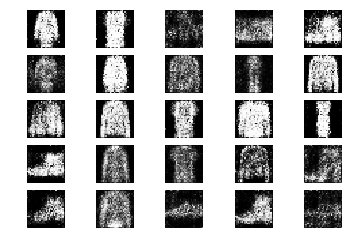

2401 [D loss: 0.572969, acc.: 75.00%] [G loss: 0.872755]
2402 [D loss: 0.594183, acc.: 64.06%] [G loss: 0.799353]
2403 [D loss: 0.609849, acc.: 67.19%] [G loss: 0.771625]
2404 [D loss: 0.611636, acc.: 70.31%] [G loss: 0.864132]
2405 [D loss: 0.611761, acc.: 65.62%] [G loss: 0.824096]
2406 [D loss: 0.594230, acc.: 68.75%] [G loss: 0.873660]
2407 [D loss: 0.684282, acc.: 48.44%] [G loss: 0.955169]
2408 [D loss: 0.631283, acc.: 62.50%] [G loss: 0.883165]
2409 [D loss: 0.614437, acc.: 68.75%] [G loss: 0.895829]
2410 [D loss: 0.602842, acc.: 67.19%] [G loss: 0.879837]
2411 [D loss: 0.689287, acc.: 59.38%] [G loss: 0.820022]
2412 [D loss: 0.643804, acc.: 62.50%] [G loss: 0.941818]
2413 [D loss: 0.587663, acc.: 68.75%] [G loss: 0.936631]
2414 [D loss: 0.548951, acc.: 75.00%] [G loss: 0.984913]
2415 [D loss: 0.670555, acc.: 56.25%] [G loss: 0.959060]
2416 [D loss: 0.638764, acc.: 62.50%] [G loss: 0.926274]
2417 [D loss: 0.657750, acc.: 56.25%] [G loss: 0.898974]
2418 [D loss: 0.637909, acc.: 5

2544 [D loss: 0.592825, acc.: 70.31%] [G loss: 0.981593]
2545 [D loss: 0.668771, acc.: 53.12%] [G loss: 0.948414]
2546 [D loss: 0.593335, acc.: 68.75%] [G loss: 0.931355]
2547 [D loss: 0.670406, acc.: 57.81%] [G loss: 0.832904]
2548 [D loss: 0.605817, acc.: 68.75%] [G loss: 0.935689]
2549 [D loss: 0.614825, acc.: 64.06%] [G loss: 0.894111]
2550 [D loss: 0.612125, acc.: 62.50%] [G loss: 0.932872]
2551 [D loss: 0.606415, acc.: 71.88%] [G loss: 1.022513]
2552 [D loss: 0.616905, acc.: 68.75%] [G loss: 0.983720]
2553 [D loss: 0.677855, acc.: 64.06%] [G loss: 0.950553]
2554 [D loss: 0.537239, acc.: 78.12%] [G loss: 0.901997]
2555 [D loss: 0.622967, acc.: 59.38%] [G loss: 0.850853]
2556 [D loss: 0.625840, acc.: 65.62%] [G loss: 0.926300]
2557 [D loss: 0.606656, acc.: 65.62%] [G loss: 0.947647]
2558 [D loss: 0.661945, acc.: 51.56%] [G loss: 0.862698]
2559 [D loss: 0.634529, acc.: 67.19%] [G loss: 0.956668]
2560 [D loss: 0.584367, acc.: 68.75%] [G loss: 0.881456]
2561 [D loss: 0.664869, acc.: 6

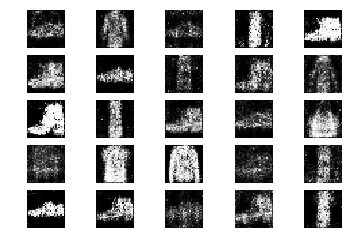

2601 [D loss: 0.587914, acc.: 68.75%] [G loss: 0.879353]
2602 [D loss: 0.597313, acc.: 65.62%] [G loss: 0.927575]
2603 [D loss: 0.602349, acc.: 71.88%] [G loss: 0.904372]
2604 [D loss: 0.677336, acc.: 57.81%] [G loss: 0.885248]
2605 [D loss: 0.562645, acc.: 68.75%] [G loss: 1.040763]
2606 [D loss: 0.630185, acc.: 60.94%] [G loss: 0.945594]
2607 [D loss: 0.673174, acc.: 60.94%] [G loss: 0.927226]
2608 [D loss: 0.691003, acc.: 60.94%] [G loss: 0.961444]
2609 [D loss: 0.635305, acc.: 68.75%] [G loss: 0.941226]
2610 [D loss: 0.609017, acc.: 60.94%] [G loss: 0.888583]
2611 [D loss: 0.616268, acc.: 70.31%] [G loss: 0.895008]
2612 [D loss: 0.611018, acc.: 64.06%] [G loss: 0.897636]
2613 [D loss: 0.637280, acc.: 65.62%] [G loss: 0.871459]
2614 [D loss: 0.613081, acc.: 71.88%] [G loss: 0.914450]
2615 [D loss: 0.647807, acc.: 64.06%] [G loss: 0.830446]
2616 [D loss: 0.701839, acc.: 59.38%] [G loss: 0.856868]
2617 [D loss: 0.576479, acc.: 67.19%] [G loss: 0.919727]
2618 [D loss: 0.631976, acc.: 6

2749 [D loss: 0.677674, acc.: 57.81%] [G loss: 0.899306]
2750 [D loss: 0.618736, acc.: 60.94%] [G loss: 0.928225]
2751 [D loss: 0.728327, acc.: 59.38%] [G loss: 0.897335]
2752 [D loss: 0.648753, acc.: 60.94%] [G loss: 0.924094]
2753 [D loss: 0.613088, acc.: 60.94%] [G loss: 0.930974]
2754 [D loss: 0.651400, acc.: 60.94%] [G loss: 1.035159]
2755 [D loss: 0.638940, acc.: 62.50%] [G loss: 0.909839]
2756 [D loss: 0.659865, acc.: 60.94%] [G loss: 0.874298]
2757 [D loss: 0.660380, acc.: 57.81%] [G loss: 0.944776]
2758 [D loss: 0.647794, acc.: 54.69%] [G loss: 0.991901]
2759 [D loss: 0.653249, acc.: 70.31%] [G loss: 0.889077]
2760 [D loss: 0.652363, acc.: 65.62%] [G loss: 0.899224]
2761 [D loss: 0.579924, acc.: 65.62%] [G loss: 0.888366]
2762 [D loss: 0.611800, acc.: 71.88%] [G loss: 0.912424]
2763 [D loss: 0.628831, acc.: 67.19%] [G loss: 0.843714]
2764 [D loss: 0.580279, acc.: 64.06%] [G loss: 0.976608]
2765 [D loss: 0.625394, acc.: 59.38%] [G loss: 0.978719]
2766 [D loss: 0.668343, acc.: 5

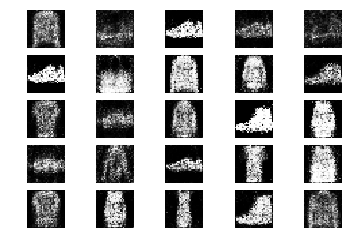

2801 [D loss: 0.666888, acc.: 62.50%] [G loss: 0.907305]
2802 [D loss: 0.640572, acc.: 64.06%] [G loss: 0.902636]
2803 [D loss: 0.660053, acc.: 60.94%] [G loss: 0.907821]
2804 [D loss: 0.600198, acc.: 60.94%] [G loss: 0.834339]
2805 [D loss: 0.654247, acc.: 50.00%] [G loss: 0.799868]
2806 [D loss: 0.672181, acc.: 54.69%] [G loss: 0.846960]
2807 [D loss: 0.651400, acc.: 56.25%] [G loss: 0.870364]
2808 [D loss: 0.655126, acc.: 54.69%] [G loss: 0.875952]
2809 [D loss: 0.682170, acc.: 53.12%] [G loss: 0.880592]
2810 [D loss: 0.611564, acc.: 65.62%] [G loss: 0.910204]
2811 [D loss: 0.704857, acc.: 48.44%] [G loss: 0.861512]
2812 [D loss: 0.605575, acc.: 75.00%] [G loss: 0.945163]
2813 [D loss: 0.618694, acc.: 67.19%] [G loss: 0.873594]
2814 [D loss: 0.668802, acc.: 57.81%] [G loss: 0.825009]
2815 [D loss: 0.621585, acc.: 68.75%] [G loss: 0.807635]
2816 [D loss: 0.660198, acc.: 57.81%] [G loss: 0.882002]
2817 [D loss: 0.656593, acc.: 54.69%] [G loss: 0.872164]
2818 [D loss: 0.621917, acc.: 6

2946 [D loss: 0.572528, acc.: 76.56%] [G loss: 0.913615]
2947 [D loss: 0.631234, acc.: 65.62%] [G loss: 0.934515]
2948 [D loss: 0.735724, acc.: 51.56%] [G loss: 0.871881]
2949 [D loss: 0.632726, acc.: 60.94%] [G loss: 0.908038]
2950 [D loss: 0.595995, acc.: 65.62%] [G loss: 0.855487]
2951 [D loss: 0.646237, acc.: 57.81%] [G loss: 0.858649]
2952 [D loss: 0.612754, acc.: 68.75%] [G loss: 0.915228]
2953 [D loss: 0.658671, acc.: 64.06%] [G loss: 0.772762]
2954 [D loss: 0.656663, acc.: 60.94%] [G loss: 0.943882]
2955 [D loss: 0.613416, acc.: 75.00%] [G loss: 0.935288]
2956 [D loss: 0.638808, acc.: 62.50%] [G loss: 0.912589]
2957 [D loss: 0.651988, acc.: 53.12%] [G loss: 1.006710]
2958 [D loss: 0.665396, acc.: 53.12%] [G loss: 0.976549]
2959 [D loss: 0.684037, acc.: 64.06%] [G loss: 0.959485]
2960 [D loss: 0.686748, acc.: 53.12%] [G loss: 0.935462]
2961 [D loss: 0.612345, acc.: 68.75%] [G loss: 0.931209]
2962 [D loss: 0.621270, acc.: 57.81%] [G loss: 0.845115]
2963 [D loss: 0.632772, acc.: 6

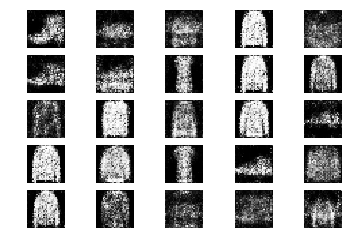

3001 [D loss: 0.650010, acc.: 62.50%] [G loss: 0.938376]
3002 [D loss: 0.644729, acc.: 60.94%] [G loss: 0.939627]
3003 [D loss: 0.618453, acc.: 62.50%] [G loss: 0.937562]
3004 [D loss: 0.569361, acc.: 73.44%] [G loss: 0.952120]
3005 [D loss: 0.603855, acc.: 75.00%] [G loss: 0.915967]
3006 [D loss: 0.670913, acc.: 56.25%] [G loss: 0.855164]
3007 [D loss: 0.604867, acc.: 78.12%] [G loss: 0.882549]
3008 [D loss: 0.609666, acc.: 70.31%] [G loss: 0.911050]
3009 [D loss: 0.627714, acc.: 67.19%] [G loss: 0.899427]
3010 [D loss: 0.584811, acc.: 71.88%] [G loss: 0.929592]
3011 [D loss: 0.616144, acc.: 56.25%] [G loss: 0.942024]
3012 [D loss: 0.673509, acc.: 57.81%] [G loss: 0.900909]
3013 [D loss: 0.591851, acc.: 64.06%] [G loss: 0.937025]
3014 [D loss: 0.656942, acc.: 56.25%] [G loss: 0.983667]
3015 [D loss: 0.639057, acc.: 60.94%] [G loss: 0.954404]
3016 [D loss: 0.640476, acc.: 65.62%] [G loss: 0.908867]
3017 [D loss: 0.623213, acc.: 68.75%] [G loss: 0.882473]
3018 [D loss: 0.671785, acc.: 5

3148 [D loss: 0.609501, acc.: 70.31%] [G loss: 0.839791]
3149 [D loss: 0.582017, acc.: 70.31%] [G loss: 0.912660]
3150 [D loss: 0.626254, acc.: 62.50%] [G loss: 0.866261]
3151 [D loss: 0.617642, acc.: 60.94%] [G loss: 0.895932]
3152 [D loss: 0.659565, acc.: 62.50%] [G loss: 0.889432]
3153 [D loss: 0.635824, acc.: 68.75%] [G loss: 0.960076]
3154 [D loss: 0.576663, acc.: 64.06%] [G loss: 0.896116]
3155 [D loss: 0.644823, acc.: 57.81%] [G loss: 0.935161]
3156 [D loss: 0.688524, acc.: 54.69%] [G loss: 0.961401]
3157 [D loss: 0.685192, acc.: 53.12%] [G loss: 0.955309]
3158 [D loss: 0.629906, acc.: 67.19%] [G loss: 0.920021]
3159 [D loss: 0.663391, acc.: 65.62%] [G loss: 0.849331]
3160 [D loss: 0.640908, acc.: 57.81%] [G loss: 0.833929]
3161 [D loss: 0.674434, acc.: 53.12%] [G loss: 0.932663]
3162 [D loss: 0.634601, acc.: 62.50%] [G loss: 0.900252]
3163 [D loss: 0.724870, acc.: 46.88%] [G loss: 0.877500]
3164 [D loss: 0.600797, acc.: 65.62%] [G loss: 0.888969]
3165 [D loss: 0.663039, acc.: 6

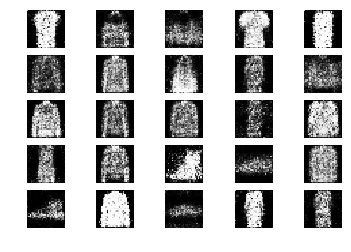

3201 [D loss: 0.601722, acc.: 70.31%] [G loss: 0.926846]
3202 [D loss: 0.640141, acc.: 65.62%] [G loss: 0.874388]
3203 [D loss: 0.601207, acc.: 71.88%] [G loss: 0.957642]
3204 [D loss: 0.626607, acc.: 65.62%] [G loss: 0.987355]
3205 [D loss: 0.613455, acc.: 68.75%] [G loss: 1.052058]
3206 [D loss: 0.652329, acc.: 62.50%] [G loss: 0.911884]
3207 [D loss: 0.674719, acc.: 62.50%] [G loss: 0.906974]
3208 [D loss: 0.634611, acc.: 67.19%] [G loss: 0.887269]
3209 [D loss: 0.704881, acc.: 62.50%] [G loss: 0.932602]
3210 [D loss: 0.614645, acc.: 71.88%] [G loss: 0.936554]
3211 [D loss: 0.682014, acc.: 50.00%] [G loss: 0.873042]
3212 [D loss: 0.638118, acc.: 65.62%] [G loss: 0.978294]
3213 [D loss: 0.606362, acc.: 67.19%] [G loss: 0.944127]
3214 [D loss: 0.639467, acc.: 62.50%] [G loss: 0.964841]
3215 [D loss: 0.654227, acc.: 60.94%] [G loss: 0.995049]
3216 [D loss: 0.674021, acc.: 59.38%] [G loss: 0.922217]
3217 [D loss: 0.643496, acc.: 59.38%] [G loss: 0.902962]
3218 [D loss: 0.660672, acc.: 6

3344 [D loss: 0.694481, acc.: 54.69%] [G loss: 0.877854]
3345 [D loss: 0.657082, acc.: 62.50%] [G loss: 0.918826]
3346 [D loss: 0.592288, acc.: 71.88%] [G loss: 0.850671]
3347 [D loss: 0.655659, acc.: 59.38%] [G loss: 0.918401]
3348 [D loss: 0.646792, acc.: 59.38%] [G loss: 0.964370]
3349 [D loss: 0.542269, acc.: 71.88%] [G loss: 0.877241]
3350 [D loss: 0.657110, acc.: 62.50%] [G loss: 0.863303]
3351 [D loss: 0.667844, acc.: 67.19%] [G loss: 0.888194]
3352 [D loss: 0.649535, acc.: 54.69%] [G loss: 0.898543]
3353 [D loss: 0.637007, acc.: 59.38%] [G loss: 0.865114]
3354 [D loss: 0.678553, acc.: 67.19%] [G loss: 0.903307]
3355 [D loss: 0.560931, acc.: 71.88%] [G loss: 0.829927]
3356 [D loss: 0.667161, acc.: 51.56%] [G loss: 0.924524]
3357 [D loss: 0.617999, acc.: 67.19%] [G loss: 0.889923]
3358 [D loss: 0.700897, acc.: 53.12%] [G loss: 0.870515]
3359 [D loss: 0.644999, acc.: 68.75%] [G loss: 0.805014]
3360 [D loss: 0.694171, acc.: 51.56%] [G loss: 0.878208]
3361 [D loss: 0.581113, acc.: 7

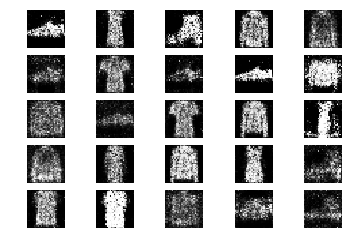

3401 [D loss: 0.644609, acc.: 67.19%] [G loss: 0.922175]
3402 [D loss: 0.602919, acc.: 71.88%] [G loss: 0.913953]
3403 [D loss: 0.624045, acc.: 62.50%] [G loss: 0.944092]
3404 [D loss: 0.627567, acc.: 65.62%] [G loss: 0.906905]
3405 [D loss: 0.581917, acc.: 71.88%] [G loss: 0.934939]
3406 [D loss: 0.645842, acc.: 56.25%] [G loss: 0.930508]
3407 [D loss: 0.617369, acc.: 70.31%] [G loss: 0.882159]
3408 [D loss: 0.600917, acc.: 60.94%] [G loss: 0.920977]
3409 [D loss: 0.616677, acc.: 70.31%] [G loss: 0.904608]
3410 [D loss: 0.589376, acc.: 64.06%] [G loss: 0.923744]
3411 [D loss: 0.613101, acc.: 64.06%] [G loss: 0.863755]
3412 [D loss: 0.710226, acc.: 48.44%] [G loss: 0.926233]
3413 [D loss: 0.542588, acc.: 73.44%] [G loss: 0.904047]
3414 [D loss: 0.578615, acc.: 68.75%] [G loss: 0.909069]
3415 [D loss: 0.687060, acc.: 53.12%] [G loss: 0.838977]
3416 [D loss: 0.679273, acc.: 56.25%] [G loss: 0.951275]
3417 [D loss: 0.591355, acc.: 71.88%] [G loss: 0.965177]
3418 [D loss: 0.683762, acc.: 5

3547 [D loss: 0.668284, acc.: 60.94%] [G loss: 0.895068]
3548 [D loss: 0.726941, acc.: 51.56%] [G loss: 0.948978]
3549 [D loss: 0.628349, acc.: 64.06%] [G loss: 0.926716]
3550 [D loss: 0.570691, acc.: 79.69%] [G loss: 0.904735]
3551 [D loss: 0.666547, acc.: 57.81%] [G loss: 0.884777]
3552 [D loss: 0.656354, acc.: 59.38%] [G loss: 0.905199]
3553 [D loss: 0.642960, acc.: 62.50%] [G loss: 0.871713]
3554 [D loss: 0.611326, acc.: 62.50%] [G loss: 0.952647]
3555 [D loss: 0.677720, acc.: 62.50%] [G loss: 0.931767]
3556 [D loss: 0.703527, acc.: 53.12%] [G loss: 0.882816]
3557 [D loss: 0.649257, acc.: 57.81%] [G loss: 0.891111]
3558 [D loss: 0.613773, acc.: 67.19%] [G loss: 0.878118]
3559 [D loss: 0.666860, acc.: 57.81%] [G loss: 0.910049]
3560 [D loss: 0.692065, acc.: 46.88%] [G loss: 0.936124]
3561 [D loss: 0.652687, acc.: 64.06%] [G loss: 0.958547]
3562 [D loss: 0.655447, acc.: 65.62%] [G loss: 0.806269]
3563 [D loss: 0.650910, acc.: 62.50%] [G loss: 0.930124]
3564 [D loss: 0.580529, acc.: 6

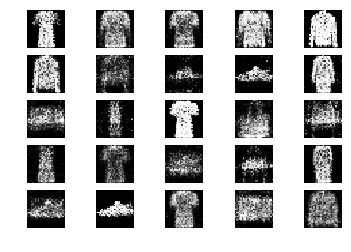

3601 [D loss: 0.607661, acc.: 60.94%] [G loss: 0.878282]
3602 [D loss: 0.638597, acc.: 56.25%] [G loss: 0.940572]
3603 [D loss: 0.617646, acc.: 64.06%] [G loss: 0.852237]
3604 [D loss: 0.620667, acc.: 64.06%] [G loss: 0.849316]
3605 [D loss: 0.648503, acc.: 56.25%] [G loss: 0.901451]
3606 [D loss: 0.621539, acc.: 57.81%] [G loss: 0.878520]
3607 [D loss: 0.612635, acc.: 71.88%] [G loss: 0.914587]
3608 [D loss: 0.734761, acc.: 54.69%] [G loss: 0.843602]
3609 [D loss: 0.663745, acc.: 59.38%] [G loss: 0.893949]
3610 [D loss: 0.581996, acc.: 65.62%] [G loss: 0.955543]
3611 [D loss: 0.652892, acc.: 60.94%] [G loss: 0.919901]
3612 [D loss: 0.650675, acc.: 53.12%] [G loss: 0.869869]
3613 [D loss: 0.614338, acc.: 68.75%] [G loss: 0.877100]
3614 [D loss: 0.693574, acc.: 53.12%] [G loss: 0.895526]
3615 [D loss: 0.613211, acc.: 68.75%] [G loss: 0.887504]
3616 [D loss: 0.660323, acc.: 57.81%] [G loss: 1.027185]
3617 [D loss: 0.695050, acc.: 60.94%] [G loss: 0.900976]
3618 [D loss: 0.595682, acc.: 6

3746 [D loss: 0.664118, acc.: 64.06%] [G loss: 0.877482]
3747 [D loss: 0.645876, acc.: 60.94%] [G loss: 0.950944]
3748 [D loss: 0.691408, acc.: 46.88%] [G loss: 0.905173]
3749 [D loss: 0.664961, acc.: 62.50%] [G loss: 0.965867]
3750 [D loss: 0.657764, acc.: 60.94%] [G loss: 0.936687]
3751 [D loss: 0.633487, acc.: 70.31%] [G loss: 0.907091]
3752 [D loss: 0.646995, acc.: 65.62%] [G loss: 0.893360]
3753 [D loss: 0.641355, acc.: 59.38%] [G loss: 0.862558]
3754 [D loss: 0.596681, acc.: 64.06%] [G loss: 0.930561]
3755 [D loss: 0.661661, acc.: 59.38%] [G loss: 0.869464]
3756 [D loss: 0.624248, acc.: 62.50%] [G loss: 0.963206]
3757 [D loss: 0.635557, acc.: 64.06%] [G loss: 0.858181]
3758 [D loss: 0.555708, acc.: 70.31%] [G loss: 0.903293]
3759 [D loss: 0.676161, acc.: 53.12%] [G loss: 0.841240]
3760 [D loss: 0.645509, acc.: 60.94%] [G loss: 0.925557]
3761 [D loss: 0.664400, acc.: 62.50%] [G loss: 0.966724]
3762 [D loss: 0.646103, acc.: 62.50%] [G loss: 0.891445]
3763 [D loss: 0.617290, acc.: 6

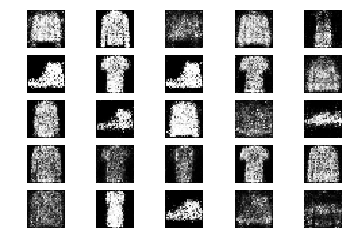

3801 [D loss: 0.614969, acc.: 65.62%] [G loss: 0.844578]
3802 [D loss: 0.642078, acc.: 64.06%] [G loss: 0.838630]
3803 [D loss: 0.665413, acc.: 56.25%] [G loss: 0.905125]
3804 [D loss: 0.575307, acc.: 67.19%] [G loss: 0.960414]
3805 [D loss: 0.596906, acc.: 73.44%] [G loss: 0.935143]
3806 [D loss: 0.651801, acc.: 64.06%] [G loss: 0.928442]
3807 [D loss: 0.634265, acc.: 65.62%] [G loss: 0.920750]
3808 [D loss: 0.616663, acc.: 68.75%] [G loss: 0.920190]
3809 [D loss: 0.619663, acc.: 65.62%] [G loss: 0.875450]
3810 [D loss: 0.598303, acc.: 70.31%] [G loss: 0.914926]
3811 [D loss: 0.620111, acc.: 67.19%] [G loss: 0.932863]
3812 [D loss: 0.702224, acc.: 56.25%] [G loss: 0.941708]
3813 [D loss: 0.653399, acc.: 65.62%] [G loss: 0.894768]
3814 [D loss: 0.591882, acc.: 64.06%] [G loss: 0.929024]
3815 [D loss: 0.651974, acc.: 59.38%] [G loss: 1.056278]
3816 [D loss: 0.556778, acc.: 76.56%] [G loss: 0.970101]
3817 [D loss: 0.658588, acc.: 64.06%] [G loss: 0.896355]
3818 [D loss: 0.661565, acc.: 6

3947 [D loss: 0.628926, acc.: 64.06%] [G loss: 0.858120]
3948 [D loss: 0.601458, acc.: 67.19%] [G loss: 0.805876]
3949 [D loss: 0.701212, acc.: 50.00%] [G loss: 0.871111]
3950 [D loss: 0.651658, acc.: 59.38%] [G loss: 0.827397]
3951 [D loss: 0.685583, acc.: 54.69%] [G loss: 0.865787]
3952 [D loss: 0.638080, acc.: 57.81%] [G loss: 0.910942]
3953 [D loss: 0.660377, acc.: 62.50%] [G loss: 0.909604]
3954 [D loss: 0.624299, acc.: 67.19%] [G loss: 0.969860]
3955 [D loss: 0.648603, acc.: 67.19%] [G loss: 0.839671]
3956 [D loss: 0.617468, acc.: 70.31%] [G loss: 0.903248]
3957 [D loss: 0.655063, acc.: 62.50%] [G loss: 0.927268]
3958 [D loss: 0.633892, acc.: 65.62%] [G loss: 0.909997]
3959 [D loss: 0.662743, acc.: 62.50%] [G loss: 0.957355]
3960 [D loss: 0.684900, acc.: 59.38%] [G loss: 0.966633]
3961 [D loss: 0.572116, acc.: 67.19%] [G loss: 0.980941]
3962 [D loss: 0.630730, acc.: 62.50%] [G loss: 0.896326]
3963 [D loss: 0.580314, acc.: 68.75%] [G loss: 0.930546]
3964 [D loss: 0.607846, acc.: 6

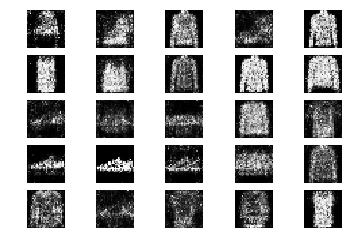

4001 [D loss: 0.689072, acc.: 60.94%] [G loss: 0.914282]
4002 [D loss: 0.640766, acc.: 64.06%] [G loss: 0.945425]
4003 [D loss: 0.620004, acc.: 68.75%] [G loss: 0.943253]
4004 [D loss: 0.667500, acc.: 60.94%] [G loss: 0.827439]
4005 [D loss: 0.601062, acc.: 67.19%] [G loss: 1.026779]
4006 [D loss: 0.649964, acc.: 65.62%] [G loss: 0.944004]
4007 [D loss: 0.586260, acc.: 70.31%] [G loss: 0.945132]
4008 [D loss: 0.730730, acc.: 57.81%] [G loss: 0.897801]
4009 [D loss: 0.589952, acc.: 73.44%] [G loss: 0.933196]
4010 [D loss: 0.659009, acc.: 60.94%] [G loss: 0.898755]
4011 [D loss: 0.695913, acc.: 50.00%] [G loss: 1.028553]
4012 [D loss: 0.638439, acc.: 64.06%] [G loss: 0.956916]
4013 [D loss: 0.636113, acc.: 60.94%] [G loss: 0.852897]
4014 [D loss: 0.598702, acc.: 67.19%] [G loss: 0.901296]
4015 [D loss: 0.590308, acc.: 75.00%] [G loss: 0.816016]
4016 [D loss: 0.644879, acc.: 64.06%] [G loss: 0.922845]
4017 [D loss: 0.720190, acc.: 56.25%] [G loss: 0.903632]
4018 [D loss: 0.667048, acc.: 6

4148 [D loss: 0.702801, acc.: 57.81%] [G loss: 0.966733]
4149 [D loss: 0.660233, acc.: 54.69%] [G loss: 0.971387]
4150 [D loss: 0.663376, acc.: 57.81%] [G loss: 0.849950]
4151 [D loss: 0.662820, acc.: 56.25%] [G loss: 0.870339]
4152 [D loss: 0.616681, acc.: 68.75%] [G loss: 0.973848]
4153 [D loss: 0.626230, acc.: 70.31%] [G loss: 0.959699]
4154 [D loss: 0.611278, acc.: 65.62%] [G loss: 0.969870]
4155 [D loss: 0.710285, acc.: 50.00%] [G loss: 0.921645]
4156 [D loss: 0.623402, acc.: 64.06%] [G loss: 0.918876]
4157 [D loss: 0.692766, acc.: 62.50%] [G loss: 0.852655]
4158 [D loss: 0.654275, acc.: 67.19%] [G loss: 0.855701]
4159 [D loss: 0.618765, acc.: 62.50%] [G loss: 1.010900]
4160 [D loss: 0.681649, acc.: 56.25%] [G loss: 0.837535]
4161 [D loss: 0.640361, acc.: 70.31%] [G loss: 0.892012]
4162 [D loss: 0.640525, acc.: 64.06%] [G loss: 0.857763]
4163 [D loss: 0.669042, acc.: 53.12%] [G loss: 0.835151]
4164 [D loss: 0.585610, acc.: 70.31%] [G loss: 0.896726]
4165 [D loss: 0.639468, acc.: 5

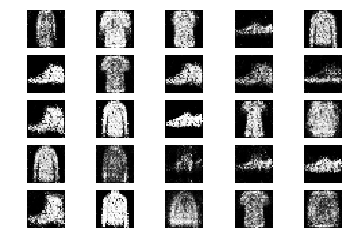

4201 [D loss: 0.575591, acc.: 76.56%] [G loss: 0.871496]
4202 [D loss: 0.620547, acc.: 64.06%] [G loss: 0.855653]
4203 [D loss: 0.668584, acc.: 65.62%] [G loss: 0.854592]
4204 [D loss: 0.718659, acc.: 51.56%] [G loss: 0.815011]
4205 [D loss: 0.610577, acc.: 71.88%] [G loss: 0.813642]
4206 [D loss: 0.685859, acc.: 60.94%] [G loss: 0.775049]
4207 [D loss: 0.652271, acc.: 56.25%] [G loss: 0.859237]
4208 [D loss: 0.647526, acc.: 60.94%] [G loss: 0.889929]
4209 [D loss: 0.661932, acc.: 59.38%] [G loss: 0.816787]
4210 [D loss: 0.632930, acc.: 65.62%] [G loss: 0.915542]
4211 [D loss: 0.645361, acc.: 54.69%] [G loss: 0.893227]
4212 [D loss: 0.684870, acc.: 51.56%] [G loss: 0.962711]
4213 [D loss: 0.748830, acc.: 50.00%] [G loss: 0.975558]
4214 [D loss: 0.674294, acc.: 65.62%] [G loss: 0.936925]
4215 [D loss: 0.649418, acc.: 60.94%] [G loss: 0.933139]
4216 [D loss: 0.582000, acc.: 73.44%] [G loss: 0.887308]
4217 [D loss: 0.666136, acc.: 59.38%] [G loss: 0.887926]
4218 [D loss: 0.668193, acc.: 5

4347 [D loss: 0.712793, acc.: 46.88%] [G loss: 0.906261]
4348 [D loss: 0.671651, acc.: 57.81%] [G loss: 0.941364]
4349 [D loss: 0.621391, acc.: 62.50%] [G loss: 0.911303]
4350 [D loss: 0.596881, acc.: 70.31%] [G loss: 0.849934]
4351 [D loss: 0.661342, acc.: 57.81%] [G loss: 0.960571]
4352 [D loss: 0.599396, acc.: 65.62%] [G loss: 0.950146]
4353 [D loss: 0.701425, acc.: 57.81%] [G loss: 0.869362]
4354 [D loss: 0.661998, acc.: 57.81%] [G loss: 0.899391]
4355 [D loss: 0.566717, acc.: 68.75%] [G loss: 0.998242]
4356 [D loss: 0.643526, acc.: 60.94%] [G loss: 1.001877]
4357 [D loss: 0.579216, acc.: 71.88%] [G loss: 0.905847]
4358 [D loss: 0.636631, acc.: 64.06%] [G loss: 1.036246]
4359 [D loss: 0.575362, acc.: 67.19%] [G loss: 0.934678]
4360 [D loss: 0.619690, acc.: 67.19%] [G loss: 0.936028]
4361 [D loss: 0.746186, acc.: 43.75%] [G loss: 0.875305]
4362 [D loss: 0.575694, acc.: 71.88%] [G loss: 0.890564]
4363 [D loss: 0.670988, acc.: 57.81%] [G loss: 0.829168]
4364 [D loss: 0.604840, acc.: 6

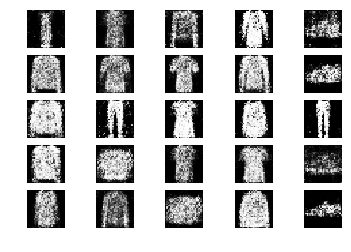

4401 [D loss: 0.599130, acc.: 70.31%] [G loss: 0.894143]
4402 [D loss: 0.639022, acc.: 60.94%] [G loss: 0.903483]
4403 [D loss: 0.599723, acc.: 75.00%] [G loss: 0.837968]
4404 [D loss: 0.707792, acc.: 51.56%] [G loss: 0.948889]
4405 [D loss: 0.607415, acc.: 75.00%] [G loss: 0.980946]
4406 [D loss: 0.645416, acc.: 67.19%] [G loss: 0.926194]
4407 [D loss: 0.676340, acc.: 57.81%] [G loss: 0.962663]
4408 [D loss: 0.639937, acc.: 62.50%] [G loss: 0.879770]
4409 [D loss: 0.621746, acc.: 65.62%] [G loss: 0.931089]
4410 [D loss: 0.770975, acc.: 57.81%] [G loss: 0.931339]
4411 [D loss: 0.698143, acc.: 54.69%] [G loss: 1.003253]
4412 [D loss: 0.648492, acc.: 60.94%] [G loss: 1.038823]
4413 [D loss: 0.711280, acc.: 56.25%] [G loss: 0.944375]
4414 [D loss: 0.679190, acc.: 53.12%] [G loss: 0.976176]
4415 [D loss: 0.688008, acc.: 50.00%] [G loss: 0.874866]
4416 [D loss: 0.625608, acc.: 70.31%] [G loss: 0.825159]
4417 [D loss: 0.608984, acc.: 65.62%] [G loss: 0.882002]
4418 [D loss: 0.650533, acc.: 7

4546 [D loss: 0.627079, acc.: 62.50%] [G loss: 0.894968]
4547 [D loss: 0.596370, acc.: 67.19%] [G loss: 0.883717]
4548 [D loss: 0.690473, acc.: 56.25%] [G loss: 0.893230]
4549 [D loss: 0.637980, acc.: 59.38%] [G loss: 0.886434]
4550 [D loss: 0.617022, acc.: 60.94%] [G loss: 0.804256]
4551 [D loss: 0.644300, acc.: 64.06%] [G loss: 0.911816]
4552 [D loss: 0.624986, acc.: 67.19%] [G loss: 0.913254]
4553 [D loss: 0.618037, acc.: 65.62%] [G loss: 0.861872]
4554 [D loss: 0.638601, acc.: 62.50%] [G loss: 0.907877]
4555 [D loss: 0.662467, acc.: 60.94%] [G loss: 0.886822]
4556 [D loss: 0.706398, acc.: 50.00%] [G loss: 0.866534]
4557 [D loss: 0.572038, acc.: 73.44%] [G loss: 0.896000]
4558 [D loss: 0.619741, acc.: 65.62%] [G loss: 0.884979]
4559 [D loss: 0.645961, acc.: 65.62%] [G loss: 0.868638]
4560 [D loss: 0.646685, acc.: 64.06%] [G loss: 0.871478]
4561 [D loss: 0.671394, acc.: 54.69%] [G loss: 0.865745]
4562 [D loss: 0.673684, acc.: 68.75%] [G loss: 0.794894]
4563 [D loss: 0.628576, acc.: 5

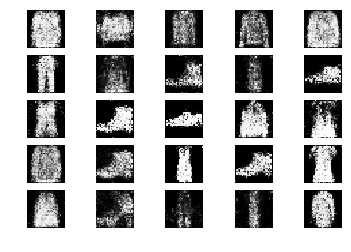

4601 [D loss: 0.601167, acc.: 65.62%] [G loss: 1.005717]
4602 [D loss: 0.545190, acc.: 70.31%] [G loss: 0.921325]
4603 [D loss: 0.646308, acc.: 62.50%] [G loss: 0.937884]
4604 [D loss: 0.569433, acc.: 75.00%] [G loss: 0.928451]
4605 [D loss: 0.640667, acc.: 62.50%] [G loss: 0.932262]
4606 [D loss: 0.668519, acc.: 62.50%] [G loss: 0.825381]
4607 [D loss: 0.673323, acc.: 57.81%] [G loss: 0.870966]
4608 [D loss: 0.637429, acc.: 60.94%] [G loss: 0.992063]
4609 [D loss: 0.665753, acc.: 59.38%] [G loss: 0.865722]
4610 [D loss: 0.626459, acc.: 65.62%] [G loss: 0.882270]
4611 [D loss: 0.642368, acc.: 59.38%] [G loss: 1.007283]
4612 [D loss: 0.618483, acc.: 65.62%] [G loss: 0.908346]
4613 [D loss: 0.622081, acc.: 60.94%] [G loss: 0.910026]
4614 [D loss: 0.654692, acc.: 59.38%] [G loss: 1.017291]
4615 [D loss: 0.640774, acc.: 70.31%] [G loss: 0.850115]
4616 [D loss: 0.586192, acc.: 70.31%] [G loss: 0.881886]
4617 [D loss: 0.633619, acc.: 64.06%] [G loss: 0.907500]
4618 [D loss: 0.640057, acc.: 5

4745 [D loss: 0.658952, acc.: 59.38%] [G loss: 0.904858]
4746 [D loss: 0.686140, acc.: 54.69%] [G loss: 0.884305]
4747 [D loss: 0.605877, acc.: 71.88%] [G loss: 0.979131]
4748 [D loss: 0.637486, acc.: 64.06%] [G loss: 0.924160]
4749 [D loss: 0.614114, acc.: 65.62%] [G loss: 0.881463]
4750 [D loss: 0.621644, acc.: 60.94%] [G loss: 0.850243]
4751 [D loss: 0.698455, acc.: 56.25%] [G loss: 0.868333]
4752 [D loss: 0.623991, acc.: 71.88%] [G loss: 0.849374]
4753 [D loss: 0.642457, acc.: 62.50%] [G loss: 0.881910]
4754 [D loss: 0.635141, acc.: 64.06%] [G loss: 0.904125]
4755 [D loss: 0.634671, acc.: 60.94%] [G loss: 0.833170]
4756 [D loss: 0.603594, acc.: 68.75%] [G loss: 0.885570]
4757 [D loss: 0.715544, acc.: 54.69%] [G loss: 0.994035]
4758 [D loss: 0.625146, acc.: 65.62%] [G loss: 0.952401]
4759 [D loss: 0.706690, acc.: 56.25%] [G loss: 0.947147]
4760 [D loss: 0.558212, acc.: 78.12%] [G loss: 1.015771]
4761 [D loss: 0.640660, acc.: 54.69%] [G loss: 1.024339]
4762 [D loss: 0.636315, acc.: 6

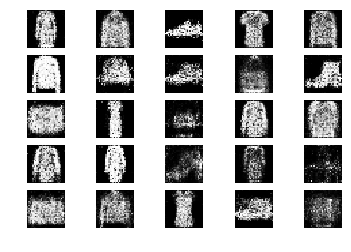

4801 [D loss: 0.683387, acc.: 59.38%] [G loss: 0.868034]
4802 [D loss: 0.596574, acc.: 75.00%] [G loss: 0.879618]
4803 [D loss: 0.666605, acc.: 57.81%] [G loss: 0.927752]
4804 [D loss: 0.647369, acc.: 56.25%] [G loss: 0.955571]
4805 [D loss: 0.623223, acc.: 70.31%] [G loss: 0.928499]
4806 [D loss: 0.603533, acc.: 65.62%] [G loss: 0.898021]
4807 [D loss: 0.638390, acc.: 67.19%] [G loss: 0.926245]
4808 [D loss: 0.683232, acc.: 54.69%] [G loss: 0.852626]
4809 [D loss: 0.600092, acc.: 70.31%] [G loss: 0.896843]
4810 [D loss: 0.637655, acc.: 57.81%] [G loss: 0.938301]
4811 [D loss: 0.638829, acc.: 65.62%] [G loss: 0.856082]
4812 [D loss: 0.619790, acc.: 71.88%] [G loss: 0.890798]
4813 [D loss: 0.633980, acc.: 64.06%] [G loss: 0.824865]
4814 [D loss: 0.685692, acc.: 51.56%] [G loss: 0.898848]
4815 [D loss: 0.607338, acc.: 70.31%] [G loss: 0.905185]
4816 [D loss: 0.657874, acc.: 59.38%] [G loss: 0.924103]
4817 [D loss: 0.708708, acc.: 57.81%] [G loss: 0.944532]
4818 [D loss: 0.584443, acc.: 7

4948 [D loss: 0.643614, acc.: 62.50%] [G loss: 0.783244]
4949 [D loss: 0.672444, acc.: 64.06%] [G loss: 0.976954]
4950 [D loss: 0.661734, acc.: 65.62%] [G loss: 0.920692]
4951 [D loss: 0.662494, acc.: 64.06%] [G loss: 0.918937]
4952 [D loss: 0.624733, acc.: 67.19%] [G loss: 0.981158]
4953 [D loss: 0.623275, acc.: 65.62%] [G loss: 0.932113]
4954 [D loss: 0.706395, acc.: 50.00%] [G loss: 0.818576]
4955 [D loss: 0.706648, acc.: 45.31%] [G loss: 0.911883]
4956 [D loss: 0.614260, acc.: 67.19%] [G loss: 1.016428]
4957 [D loss: 0.704154, acc.: 51.56%] [G loss: 0.957918]
4958 [D loss: 0.646154, acc.: 67.19%] [G loss: 0.947253]
4959 [D loss: 0.622599, acc.: 68.75%] [G loss: 0.939575]
4960 [D loss: 0.698666, acc.: 56.25%] [G loss: 0.859891]
4961 [D loss: 0.647661, acc.: 56.25%] [G loss: 0.946376]
4962 [D loss: 0.592230, acc.: 65.62%] [G loss: 1.039338]
4963 [D loss: 0.646855, acc.: 59.38%] [G loss: 0.983642]
4964 [D loss: 0.639108, acc.: 62.50%] [G loss: 0.978545]
4965 [D loss: 0.618083, acc.: 7

In [9]:
gan = GAN()
gan.train(epochs=5000, batch_size=32, sample_interval=200)

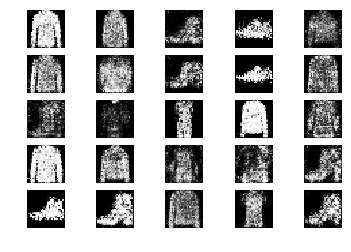

In [10]:
latent_dim = 100
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
#fig.savefig("images/%d.png" % epoch)
plt.show()
plt.close()